<a href="https://colab.research.google.com/github/bcmin1018/NLP/blob/main/Classification/Toxic_comment_classification/Notebooks/Toxic_comment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 7.8 MB/s 
     |████████████████████████████████| 596 kB 57.7 MB/s 
     |████████████████████████████████| 86 kB 4.7 MB/s 
     |████████████████████████████████| 6.6 MB 50.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import torch
import torch.nn as nn
import transformers
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_notebook
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
import os, sys 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#train
!gdown --id 1-0kJHNDTDLvx8U7hrN9kq9T3aLaWI6wW
#train2
!gdown --id 1-2N4ZDmvkhE02UkZ4OiziCrk-Cy9K9hY
#valid
!gdown --id 1fh2Wtzjx7t9mIv6-ntUB-dv27nfJfFba
#test
!gdown --id 1K6bu85ANf1niUOUP1j4Zdd1mEN7wdIVT
#sample_submission
!gdown --id 1gyVdX4syHrDCum7e6qiDOFkXVcbY2tGO

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-0kJHNDTDLvx8U7hrN9kq9T3aLaWI6wW
To: /content/jigsaw-unintended-bias-train(clean).csv
100% 1.43G/1.43G [00:05<00:00, 265MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-2N4ZDmvkhE02UkZ4OiziCrk-Cy9K9hY
To: /content/jigsaw-toxic-comment-train(clean).csv
100% 178M/178M [00:00<00:00, 292MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.


In [5]:
train_data_path= "./jigsaw-unintended-bias-train(clean).csv"
train2_data_path= "./jigsaw-toxic-comment-train(clean).csv"
valid_data_path= "./validation.csv"
test_data_path ="./test.csv"
sample_submission_path = "./sample_submission.csv"

train_data = pd.read_csv(train_data_path, lineterminator='\n', usecols=['clean_comment_text','toxic'])
train2_data = pd.read_csv(train2_data_path, usecols=['clean_comment_text','toxic'])
valid_data = pd.read_csv(valid_data_path, usecols=['comment_text','toxic'])
test_data = pd.read_csv(test_data_path, usecols=['content'])
sample_submission = pd.read_csv(sample_submission_path)

In [6]:
print(len(train_data))
print(len(train2_data))
print(len(valid_data))
print(len(test_data))

1902194
223549
8000
63812


In [7]:
# 학습데이터의 toxic 컬럼의 threshold 0.5
train_data_new_target = np.where(train_data.toxic > 0.5, 1, 0)
train_data.toxic = train_data_new_target

In [8]:
train_cat = pd.concat([
  train_data[['clean_comment_text', 'toxic']].query('toxic==0')[:70000],
  train_data[['clean_comment_text', 'toxic']].query('toxic==1')[:20000],
  train2_data[['clean_comment_text', 'toxic']].query('toxic==1')[:10000]
])

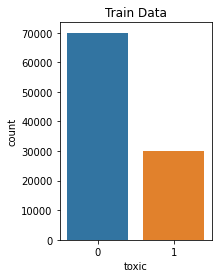

In [9]:
# 학습 데이터 비율 (1: toxic, 0: nontoxic)
plt.subplot(1,2,2)
sns.countplot(train_cat['toxic'])
plt.title('Train Data')

plt.show()

In [10]:
print("train comment 최대 길이: ", max(len(comment) for comment in train_cat.clean_comment_text.values))
print("train comment 평균 길이: ", sum(map(len, train_cat.clean_comment_text))/len(train_cat))
print("valid comment 최대 길이: ", max(len(comment) for comment in valid_data.comment_text.values))
print("valid comment 평균 길이: ", sum(map(len, valid_data.comment_text))/len(valid_data))
print("test comment 최대 길이: ", max(len(comment) for comment in test_data.content.values))
print("test comment 평균 길이: ", sum(map(len, test_data.content))/len(test_data))

train comment 최대 길이:  5000
train comment 평균 길이:  293.25549
valid comment 최대 길이:  1785
valid comment 평균 길이:  368.988
test comment 최대 길이:  7794
test comment 평균 길이:  378.2348617814831


In [11]:
# df_train = train2_data[0:1000]
df_train_cat = train_cat
df_valid = valid_data
df_test = test_data

print(len(df_train_cat))
print(len(df_valid))
print(len(df_test))

100000
8000
63812


In [12]:
# dataset.py
class BERTDataset:
  def __init__(self, comment_text, target):
    self.comment_text = comment_text
    self.target = target
    self.tokenizer = TOKENIZER
    self.max_len = MAX_LEN

  def __len__(self):
    return len(self.comment_text)

  def __getitem__(self, item):
    comment_text = str(self.comment_text[item])
    comment_text = " ".join(comment_text.split())

    inputs = self.tokenizer.encode_plus(
        comment_text,
        None,
        add_special_tokens=True,
        truncation=True,
        max_length = self.max_len
    )

    ids = inputs["input_ids"]
    mask = inputs['attention_mask']
    token_type_ids = inputs["token_type_ids"]

    padding_length = self.max_len - len(ids)
    ids = ids + ([0] * padding_length)
    mask = mask + ([0] * padding_length)
    token_type_ids = token_type_ids + ([0] * padding_length)

    return {
        'ids' : torch.tensor(ids, dtype=torch.long),
        'mask' : torch.tensor(mask, dtype=torch.long),
        'token_type_ids' : torch.tensor(token_type_ids, dtype=torch.long),
        'target' : torch.tensor(self.target[item], dtype=torch.float)
    }

In [13]:
# model.py

class BERTBaseUncased(nn.Module):
  def __init__(self):
    super(BERTBaseUncased, self).__init__()
    self.bert = transformers.BertModel.from_pretrained('bert-base-multilingual-cased')
    self.bert_drop = nn.Dropout(0.1)
    # mean, max pooling (768 * 2)
    self.out = nn.Linear(768 * 2, 1)

  def forward(self, ids, mask, token_type_ids):
    outputs = self.bert(
        ids,
        attention_mask = mask,
        token_type_ids = token_type_ids
    )

    mean_pooling = torch.mean(outputs[0], 1)
    max_pooling, _ = torch.max(outputs[0], 1)
    cat = torch.cat((mean_pooling, max_pooling), 1)

    bo = self.bert_drop(cat)
    output = self.out(bo)
    return output

In [14]:
#engine.py

def loss_fn(outputs, targets):
  return nn.BCEWithLogitsLoss()(outputs, targets.float().view(-1, 1))

def train(data_loader, model, optimizer, device, scheduler):
  model.train()
  avg_loss = 0
  for batch_idx, data in enumerate(data_loader):
    ids = data['ids']
    token_type_ids = data['token_type_ids']
    mask = data['mask']
    targets = data['target']

    ids = ids.to(device, dtype=torch.long)
    token_type_ids = token_type_ids.to(device, dtype=torch.long)
    mask = mask.to(device, dtype=torch.long)
    targets = targets.to(device, dtype=torch.long)

    optimizer.zero_grad()
    outputs = model(
        ids = ids,
        mask = mask,
        token_type_ids = token_type_ids
    )

    loss = loss_fn(outputs, targets)
    if batch_idx % 1000 == 0:
      print(f'train_batch_idx={batch_idx}, train_loss={loss}')
      writer.add_scalar("Loss/train", loss, batch_idx)
    
    loss.backward()
    optimizer.step()
    scheduler.step()



def eval(data_loader, model, device):
  model.eval()
  fin_targets = []
  fin_outputs = []
  with torch.no_grad():
    for batch_idx, data in enumerate(data_loader):
      ids = data['ids']
      token_type_ids = data['token_type_ids']
      mask = data['mask']
      targets = data['target']

      ids = ids.to(device, dtype=torch.long)
      token_type_ids = token_type_ids.to(device, dtype=torch.long)
      mask = mask.to(device, dtype=torch.long)
      targets = targets.to(device, dtype=torch.long)

      outputs = model(
        ids = ids,
        mask = mask,
        token_type_ids = token_type_ids
      )
      fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
      fin_targets.extend(targets.cpu().detach().numpy().tolist())
  return fin_outputs, fin_targets

In [15]:
# train.py
def run(train_data_loader, valid_data_loader):
  device = torch.device("cuda")
  model = BERTBaseUncased()
  model.to(device)

  param_optimizer = list(model.named_parameters())
  no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
  optimizer = AdamW(model.parameters(), lr=LR, betas=(BETA1, BETA2), weight_decay=WEIGHT_DECAY)
  # optimizer_parameters = [
  #   {'params' : [p for n, p in param_optimizer if not any (nd in n for nd in no_decay)], 'weight_decay': 0.001},
  #   {'params' : [p for n, p in param_optimizer if any (nd in n for nd in no_decay)], 'weight_decay': 0.0}
  # ]

  num_train_steps = int(len(df_train_cat) / TRAIN_BATCH_SIZE * EPOCHS)
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0,
                                              num_training_steps = num_train_steps)

  best_accuracy = 0
  for epoch in range(EPOCHS):
    train(train_data_loader, model, optimizer, device, scheduler)
    outputs, targets = eval(valid_data_loader, model, device)
    # targets = np.where(targets >=0.5, targets, 0)
    accuracy = metrics.roc_auc_score(targets, outputs)
    # precision = precision_score(targets, outputs)
    # recall = recall_score(targets, outputs)
    writer.add_scalar("AUC Score/Valid", accuracy, epoch)
    print("epoch {}    AUC Score {}".format(epoch+1, accuracy))
    
    # print((f"AUC Score = {accuracy}" f"Precision = {precision}" f"Recall = {recall}"))
    if accuracy > best_accuracy:
      torch.save(model.state_dict(), MODEL_PATH)
      best_accuarcy = accuracy

In [16]:
# config.py
MAX_LEN = 300
TRAIN_BATCH_SIZE =16
VALID_BATCH_SIZE =16
EPOCHS = 5
LR = 1e-4
WEIGHT_DECAY = 1e-2
BETA1 = 0.9
BETA2 = 0.999
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/model.pt"
TOKENIZER = transformers.BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [17]:
train_dataset = BERTDataset(
    comment_text = df_train_cat.clean_comment_text.values,
    target = df_train_cat.toxic.values
)
train_data_loader = DataLoader(
    train_dataset,
    batch_size = TRAIN_BATCH_SIZE,
    num_workers = 2,
    shuffle=True
)
valid_dataset = BERTDataset(
    comment_text = df_valid.comment_text.values,
    target = df_valid.toxic.values
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = VALID_BATCH_SIZE,
    num_workers = 1,
    shuffle=True
)

In [ ]:
run(train_data_loader, valid_data_loader )

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train_batch_idx=0, train_loss=0.6308073997497559
train_batch_idx=1000, train_loss=0.6861640810966492
train_batch_idx=2000, train_loss=0.735804557800293
train_batch_idx=3000, train_loss=0.629437267780304
train_batch_idx=4000, train_loss=0.7672089338302612
train_batch_idx=5000, train_loss=0.7129442691802979
train_batch_idx=6000, train_loss=0.5365703105926514
epoch 1    AUC Score 0.4931393282175068
train_batch_idx=0, train_loss=0.5670086145401001
train_batch_idx=1000, train_loss=0.5767475962638855
train_batch_idx=2000, train_loss=0.6186537146568298
train_batch_idx=3000, train_loss=0.7366797924041748
train_batch_idx=4000, train_loss=0.7191581726074219
train_batch_idx=5000, train_loss=0.7567875385284424
train_batch_idx=6000, train_loss=0.5129947662353516
epoch 2    AUC Score 0.49703936544535315
train_batch_idx=0, train_loss=0.4661884605884552
train_batch_idx=1000, train_loss=0.5683313608169556
train_batch_idx=2000, train_loss=0.8373364210128784
train_batch_idx=3000, train_loss=0.67738342285

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

In [ ]:
#test_dataset.py
class BERTDatasetTest:
    def __init__(self, comment_text):
        self.comment_text = comment_text
        self.tokenizer = TOKENIZER
        self.max_length = MAX_LEN

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, item):
        comment_text = str(self.comment_text[item])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
        )
        ids = inputs["input_ids"]
        token_type_ids = inputs["token_type_ids"]
        mask = inputs["attention_mask"]
        
        padding_length = self.max_length - len(ids)
        
        ids = ids + ([0] * padding_length)
        mask = mask + ([0] * padding_length)
        token_type_ids = token_type_ids + ([0] * padding_length)
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)
        }

In [ ]:
test_dataset = BERTDatasetTest(
    comment_text = df_test.content.values
)

test_data_loader = DataLoader(
    test_dataset,
    batch_size = VALID_BATCH_SIZE,
    num_workers = 1,
    shuffle=False
)

In [ ]:
# prediction.py

def pred(data_loader):
  device = torch.device("cuda")
  model = BERTBaseUncased().to(device)
  model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/model.pt'))
  model.eval()

  fin_outputs = []
  with torch.no_grad():
    for batch_idx, data in enumerate(data_loader):
      ids = data['ids']
      token_type_ids = data['token_type_ids']
      mask = data['mask']

      ids = ids.to(device, dtype=torch.long)
      token_type_ids = token_type_ids.to(device, dtype=torch.long)
      mask = mask.to(device, dtype=torch.long)

      outputs = model(
        ids = ids,
        mask = mask,
        token_type_ids = token_type_ids
      )

      fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
  return fin_outputs

In [ ]:
prediction = pred(test_data_loader)

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
sample_submission.loc[:, 'toxic'] = np.array(prediction)
sample_submission.to_csv('/content/drive/MyDrive/Colab Notebooks/sample_submission2.csv', index=False)

# 테스트코드

In [ ]:
device = torch.device("cuda")
bert = transformers.BertModel.from_pretrained('bert-base-multilingual-cased').to(device)

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device("cuda")
# device = torch.device('cpu')
model = BERTBaseUncased().to(device)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
for batch_idx, data in tqdm(enumerate(train_data_loader), total=len(train_data_loader)):
   ids = data['ids']
   token_type_ids = data['token_type_ids']
   mask = data['mask']
   targets = data['target']

   ids = ids.to(device, dtype=torch.long)
   token_type_ids = token_type_ids.to(device, dtype=torch.long)
   mask = mask.to(device, dtype=torch.long)
   targets = targets.to(device, dtype=torch.long)
   break

  0%|          | 0/63 [00:00<?, ?it/s]


In [ ]:
print(ids)
print(token_type_ids)
print(mask)
print(targets)

tensor([[  101,   177,   173,  ..., 10105, 27116,   102],
        [  101,   183, 10237,  ...,     0,     0,     0],
        [  101, 27420, 17928,  ...,     0,     0,     0],
        ...,
        [  101, 13028, 10301,  ...,     0,     0,     0],
        [  101,   177, 11337,  ..., 12277, 10261,   102],
        [  101,   177, 11758,  ..., 10108, 10105,   102]], device='cuda:0')
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


In [ ]:
# bert = transformers.BertModel.from_pretrained('bert-base-multilingual-cased').to(device)
model = BERTBaseUncased().to(device)
outputs = model(
        ids,
        mask = mask,
        token_type_ids = token_type_ids
    )

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
output = torch.sigmoid(outputs)

In [ ]:
a1 = outputs.detach().cpu().numpy().tolist()

In [ ]:
a2 = output.detach().cpu().numpy().tolist()

In [ ]:
precision = precision_score(a1, a2)
    # recall = recall_score(targets, outputs)

ValueError: ignored

In [ ]:
mean_pooling = torch.mean(outputs[0], 1)
max_pooling = torch.max(outputs[0], 1)[0]
print(mean_pooling)
print(max_pooling)

IndexError: ignored

In [ ]:
cat = torch.cat((mean_pooling, max_pooling),1)
print(cat)

NameError: ignored

In [ ]:
out = nn.Linear(768*2, 1).to(device)

In [ ]:
pred = out(cat)

NameError: ignored

In [ ]:
pred

NameError: ignored

In [ ]:
eval 